# Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(42)

# Data

## Image path

In [2]:
train_dir = "../input/tomatoleaf/tomato/train"
test_dir = "../input/tomatoleaf/tomato/val"

## Data Rescaling and augmentation

In [3]:
#import tensorflow as tf

# Define the image size
image_size = (224, 224)

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(image_size[0], image_size[1], 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name="data_augmentation")


## Load datasets (Shuffle and prefetch)

In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=42
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = test_data.class_names
valid_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


## Visualize data

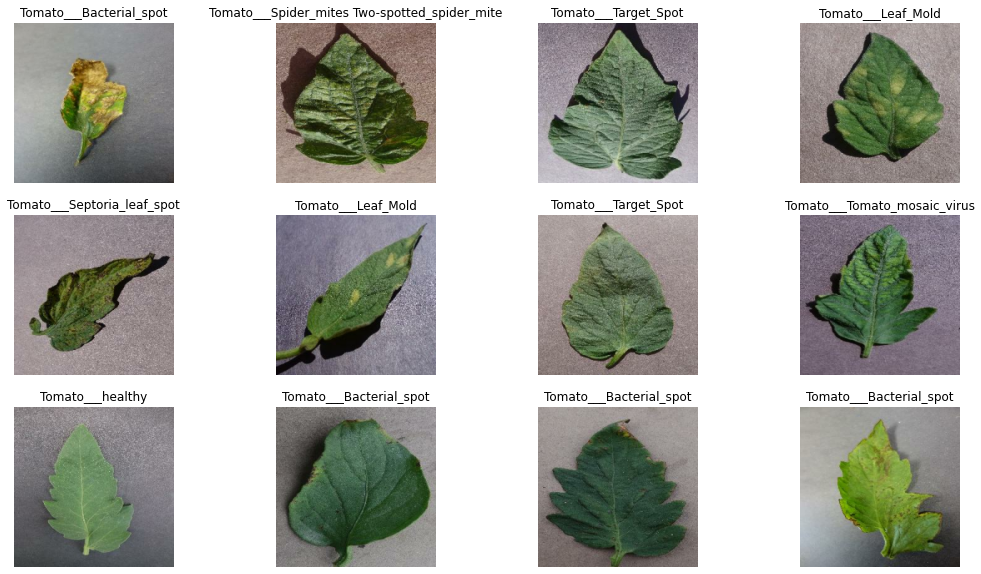

In [5]:
plt.figure(figsize=(18,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

## Augmented image view

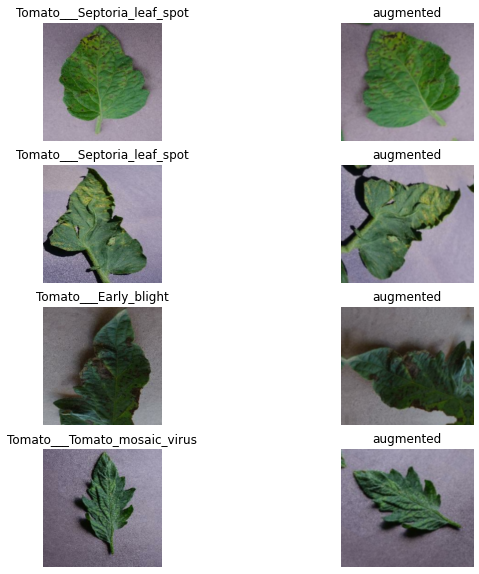

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

# Create Checkpoint

In [7]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

# Create model

In [8]:
import tensorflow as tf

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

])

## Summary

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0

## Compile model

In [10]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

## Fit the model

In [ ]:
history = model.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

Epoch 1/10
313/313 [==============================] - 155s 489ms/step - loss: 2.1251 - accuracy: 0.2076 - val_loss: 1.8914 - val_accuracy: 0.3640
Epoch 2/10
313/313 [==============================] - 153s 489ms/step - loss: 1.7335 - accuracy: 0.3805 - val_loss: 1.6043 - val_accuracy: 0.4220
Epoch 3/10
313/313 [==============================] - 152s 485ms/step - loss: 1.4908 - accuracy: 0.4729 - val_loss: 1.4319 - val_accuracy: 0.4910
Epoch 4/10
313/313 [==============================] - 153s 490ms/step - loss: 1.3742 - accuracy: 0.5141 - val_loss: 1.2623 - val_accuracy: 0.5830
Epoch 5/10
313/313 [==============================] - 163s 522ms/step - loss: 1.2650 - accuracy: 0.5574 - val_loss: 1.1524 - val_accuracy: 0.6130
Epoch 6/10
313/313 [==============================] - 156s 498ms/step - loss: 1.1570 - accuracy: 0.5949 - val_loss: 1.0452 - val_accuracy: 0.6520
Epoch 7/10
313/313 [==============================] - 153s 490ms/step - loss: 1.1016 - accuracy: 0.6150 - val_loss: 0.9412 -

# Create plot_loss_curve function

In [19]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## plot the model

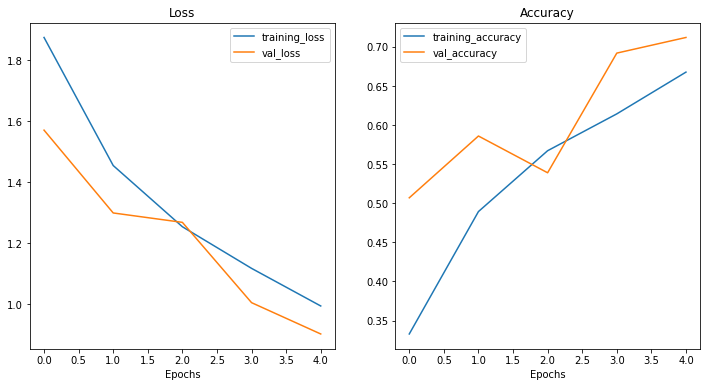

In [20]:
plot_loss_curves(history)

# Evaluate model

In [21]:
model.evaluate(test_data)

32/32 [==============================] - 3s 93ms/step - loss: 0.9031 - accuracy: 0.7120


[0.9031111001968384, 0.7120000123977661]

In [23]:
model.evaluate(train_data)

313/313 [==============================] - 25s 79ms/step - loss: 0.8824 - accuracy: 0.6990


[0.8824491500854492, 0.6990000009536743]

## Evaluate best model

### Load the best weight

In [24]:
model.load_weights(checkpoint_path)

In [25]:
model.evaluate(train_data), model.evaluate(test_data)

32/32 [==============================] - 3s 92ms/step - loss: 0.9031 - accuracy: 0.7120


([0.8824489116668701, 0.6990000009536743],
 [0.9031110405921936, 0.7120000123977661])

# Load pretrain model

## Download pre train model

In [26]:
! wget "https://github.com/HSAkash/Tomato-leaf-disease/raw/main/pretrain_model.h5"

--2023-06-29 08:59:18--  https://github.com/HSAkash/Tomato-leaf-disease/raw/main/pretrain_model.h5
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSAkash/Tomato-leaf-disease/main/pretrain_model.h5 [following]
--2023-06-29 08:59:18--  https://raw.githubusercontent.com/HSAkash/Tomato-leaf-disease/main/pretrain_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173280 (169K) [application/octet-stream]
Saving to: ‘pretrain_model.h5’

pretrain_model.h5   100%[===================>] 169.22K  --.-KB/s    in 0.03s   

2023-06-29 08:59:18 (5.98 MB/s) - ‘pretrain_model.h5’ saved [173280/173280]



## Laod model

In [27]:
load_model = tf.keras.models.load_model("pretrain_model.h5")

## summary of load data

In [28]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0

## Evaluate load model with valid data or test_data

In [29]:
load_model.evaluate(train_data),load_model.evaluate(test_data)

32/32 [==============================] - 3s 93ms/step - loss: 0.2603 - accuracy: 0.9420


([0.11484742164611816, 0.9645000100135803],
 [0.2602567672729492, 0.9419999718666077])

# Prediction && visualize

In [ ]:
plt.figure(figsize=(18,12))
for image_batch,label_batch in test_data.take(1):
    predictions = load_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

# Confusion matrix

In [24]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )
  
  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)


## Predict y_pred and get y_true

In [25]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

## Plot confusion matrix

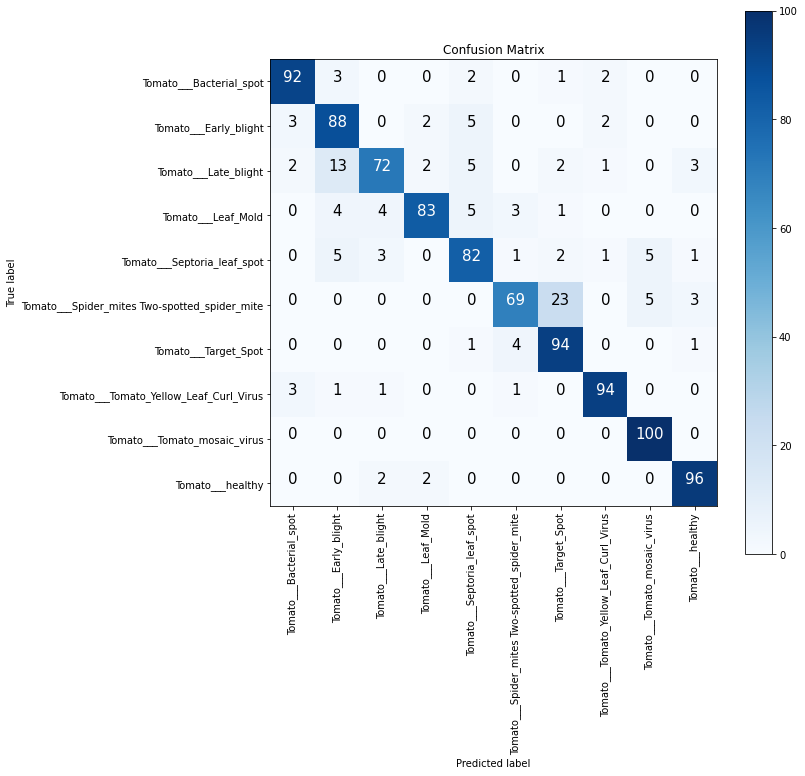

In [26]:
make_confusion_matrix(y_true, y_pred, class_names)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names)) 

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.92      0.92      0.92       100
                        Tomato___Early_blight       0.77      0.88      0.82       100
                         Tomato___Late_blight       0.88      0.72      0.79       100
                           Tomato___Leaf_Mold       0.93      0.83      0.88       100
                  Tomato___Septoria_leaf_spot       0.82      0.82      0.82       100
Tomato___Spider_mites Two-spotted_spider_mite       0.88      0.69      0.78       100
                         Tomato___Target_Spot       0.76      0.94      0.84       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.94      0.94      0.94       100
                 Tomato___Tomato_mosaic_virus       0.91      1.00      0.95       100
                             Tomato___healthy       0.92      0.96      0.94       100

                                     accu

# #Implimentation of VGG19 Model !

In [12]:
import tensorflow as tf

# Load the pre-trained VGG19 model without the top classification layers
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
vgg19.trainable = False

# Create your own classification layers
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    vgg19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

80150528/80134624 [==============================] - 4s 0us/step


In [13]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 26,449,738
Trainable params: 6,425,354
Non-trainable params: 20,024,384
_________________________________________________________________


In [15]:
# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #Early Stopping !


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
 checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:

# Model fitting
history = model2.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/50
123/313 [==========>...................] - ETA: 28:37 - loss: 4.9693 - accuracy: 0.3878

# #Model Evaluation ! 

In [36]:
model2.evaluate(train_data)

313/313 [==============================] - 24s 76ms/step - loss: 0.0914 - accuracy: 0.9683


[0.09144852310419083, 0.9682999849319458]

In [39]:
model2.evaluate(test_data)

32/32 [==============================] - 3s 82ms/step - loss: 0.8685 - accuracy: 0.8430


[0.8685036301612854, 0.8429999947547913]

# #Plotting the Confusion matrix of the given data !

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [41]:
import numpy as np

y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)


In [43]:
cm=confusion_matrix(y_true, y_pred)

In [44]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                         ):
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix ! ")
        
    else:
        print('Confustion matrix , without normalization !')
        
    print(cm)
    
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]>thresh else 'black')
         
    plt.tight_layout()
    plt.ylabel('True label')

Confustion matrix , without normalization !
[[78  5  2  0  0  1  4  7  0  3]
 [ 5 71 14  0  0  2  3  2  0  3]
 [ 5 16 43  2  1 13  0  5  2 13]
 [ 0 17 19 33  9  8  0  3  9  2]
 [ 2  7 10  2 34 13  7  2 15  8]
 [ 0 12  3  0  0 50 27  1  5  2]
 [ 0 13  0  0  0  4 73  0  3  7]
 [ 2  8  0  1  2 15  0 71  1  0]
 [ 0  0  0  4  0  0  0  0 96  0]
 [ 7  3  0  3  1  0  7  0  0 79]]


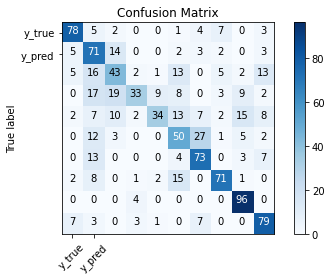

In [45]:
cm_plot_labels=['y_true','y_pred']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [46]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model2.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

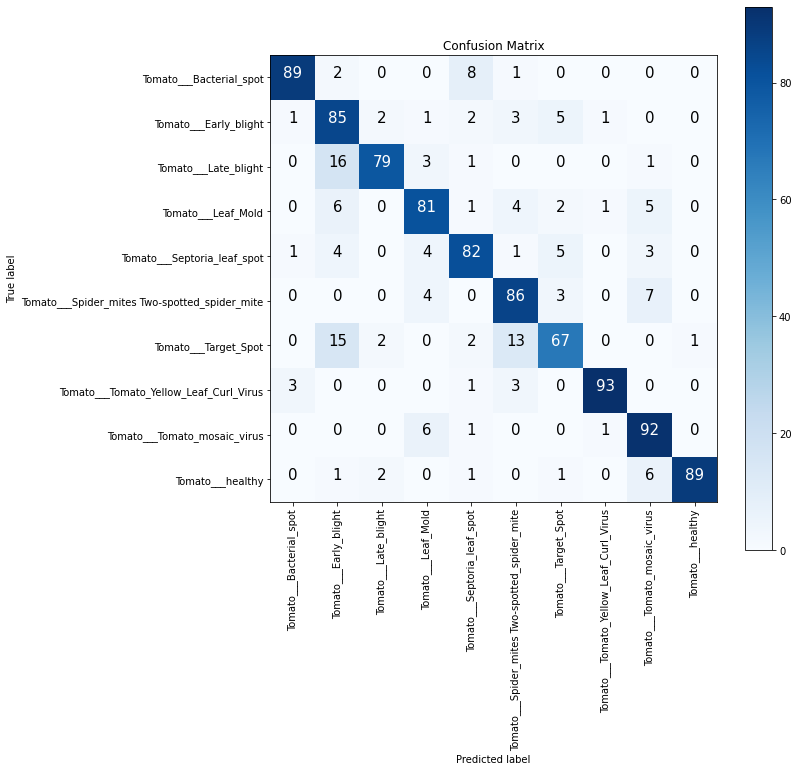

In [47]:
make_confusion_matrix(y_true, y_pred, class_names)

# #Accuracy,Precesion,Recall & F1 Score of above data !

In [48]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the ground truth labels and predicted labels stored in numpy arrays
# y_true: numpy array of ground truth labels
# y_pred: numpy array of predicted labels

# Convert the predicted probabilities to predicted class labels
#y_pred_class = np.argmax(y_pred, axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.843
Precision: 0.8528259773676962
Recall: 0.843
F1 Score: 0.8445169955774183


# #DONE !


# #Implimentation of VGG16 Model !

In [49]:
import tensorflow as tf

# Load the pre-trained VGG16 model without the top classification layers
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
vgg16.trainable = False

# Create your own classification layers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


58900480/58889256 [==============================] - 0s 0us/step


In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________


In [51]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #Early Stopping !

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [55]:
# Model fitting
history = model.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/20
313/313 [==============================] - 23s 72ms/step - loss: 0.6650 - accuracy: 0.7630 - val_loss: 0.8230 - val_accuracy: 0.8070
Epoch 2/20
313/313 [==============================] - 23s 73ms/step - loss: 0.6575 - accuracy: 0.7589 - val_loss: 0.7947 - val_accuracy: 0.8250
Epoch 3/20
313/313 [==============================] - 23s 72ms/step - loss: 0.6544 - accuracy: 0.7697 - val_loss: 0.6695 - val_accuracy: 0.8440
Epoch 4/20
313/313 [==============================] - 23s 73ms/step - loss: 0.6256 - accuracy: 0.7758 - val_loss: 0.7132 - val_accuracy: 0.8370
Epoch 5/20
313/313 [==============================] - 23s 73ms/step - loss: 0.5871 - accuracy: 0.7961 - val_loss: 0.6742 - val_accuracy: 0.8360
Epoch 9/20
313/313 [==============================] - 23s 72ms/step - loss: 0.5655 - accuracy: 0.7996 - val_loss: 0.6913 - val_accuracy: 0.8390
Epoch 10/20
313/313 [==============================] - 23s 73ms/step - loss: 0.5622 - accuracy: 0.8007 - val_loss: 0.7752 - val_accuracy

# #Model Evaluation !

In [56]:
model.evaluate(train_data)

313/313 [==============================] - 20s 64ms/step - loss: 0.1014 - accuracy: 0.9736


[0.10140439122915268, 0.9735999703407288]

In [57]:
model.evaluate(test_data)

32/32 [==============================] - 3s 70ms/step - loss: 0.7752 - accuracy: 0.8370


[0.7752457857131958, 0.8370000123977661]

# #Drawing the confusion matrix !

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [59]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model2.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

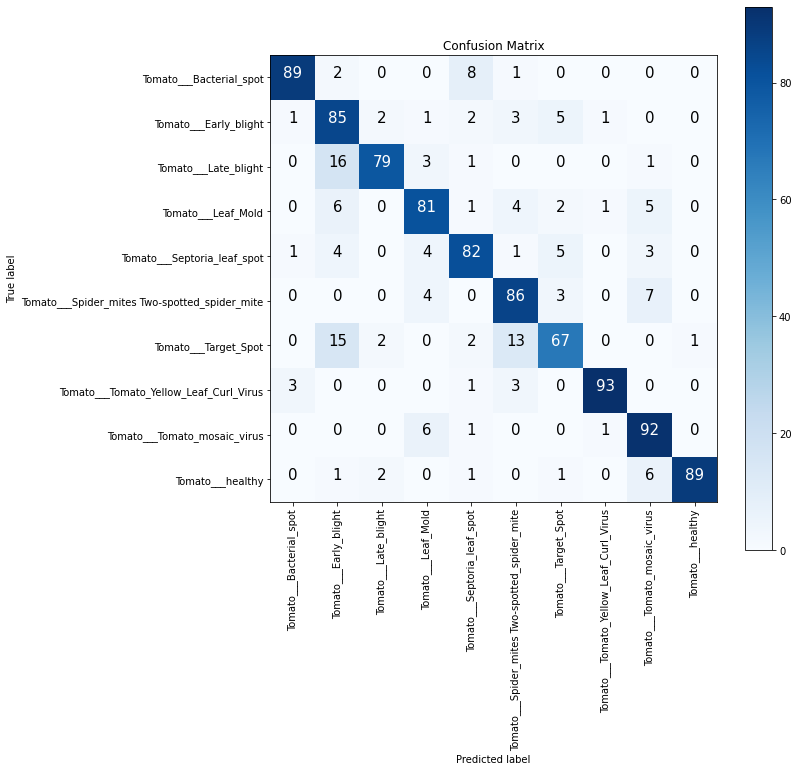

In [61]:
make_confusion_matrix(y_true, y_pred, class_names)

In [62]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the ground truth labels and predicted labels stored in numpy arrays
# y_true: numpy array of ground truth labels
# y_pred: numpy array of predicted labels

# Convert the predicted probabilities to predicted class labels
#y_pred_class = np.argmax(y_pred, axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.843
Precision: 0.8528259773676962
Recall: 0.843
F1 Score: 0.8445169955774183


# #Implimentation of ResNet50 Model !

In [63]:
import tensorflow as tf

# Load the pre-trained ResNet50 model without the top classification layers
resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
resnet50.trainable = False

# Create your own classification layers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    resnet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


94781440/94765736 [==============================] - 2s 0us/step


In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 49,280,650
Trainable params: 25,692,938
Non-trainable params: 23,587,712
_________________________________________________________________


In [67]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #Early Stopping !

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [70]:
# Model fitting
history = model.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/20
313/313 [==============================] - 26s 72ms/step - loss: 2.4677 - accuracy: 0.5038 - val_loss: 0.9242 - val_accuracy: 0.7120
Epoch 2/20
313/313 [==============================] - 21s 68ms/step - loss: 1.1515 - accuracy: 0.6144 - val_loss: 0.6472 - val_accuracy: 0.8190
Epoch 3/20
313/313 [==============================] - 21s 68ms/step - loss: 0.8868 - accuracy: 0.6947 - val_loss: 0.5712 - val_accuracy: 0.8310
Epoch 4/20
313/313 [==============================] - 21s 68ms/step - loss: 0.8242 - accuracy: 0.7118 - val_loss: 0.5347 - val_accuracy: 0.8360
Epoch 5/20
313/313 [==============================] - 21s 67ms/step - loss: 0.7621 - accuracy: 0.7311 - val_loss: 0.5048 - val_accuracy: 0.8590
Epoch 6/20
313/313 [==============================] - 21s 67ms/step - loss: 0.6378 - accuracy: 0.7818 - val_loss: 0.4154 - val_accuracy: 0.8850
Epoch 7/20
313/313 [==============================] - 21s 67ms/step - loss: 0.6215 - accuracy: 0.7727 - val_loss: 0.3992 - val_accuracy:

# #Model Evaluation ! ,Part

In [71]:
model.evaluate(train_data)

313/313 [==============================] - 18s 59ms/step - loss: 0.0549 - accuracy: 0.9832


[0.05491013824939728, 0.9832000136375427]

In [72]:
model.evaluate(test_data)

32/32 [==============================] - 3s 66ms/step - loss: 0.4989 - accuracy: 0.8840


[0.49887707829475403, 0.8840000033378601]

# #Drawing the confusion matrix !

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [74]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

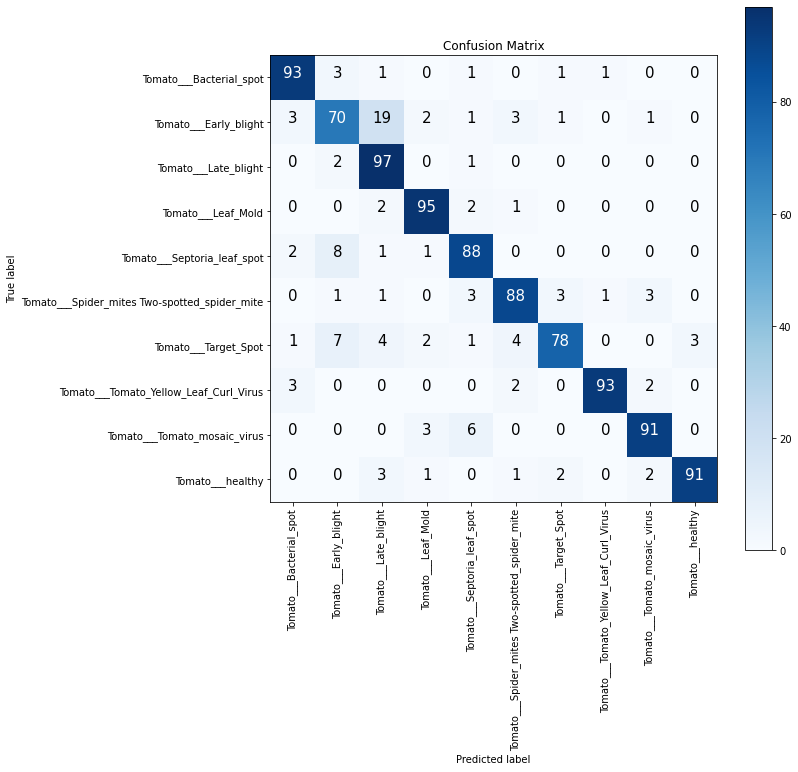

In [75]:
make_confusion_matrix(y_true, y_pred, class_names)

# #Calculation of Accuracy,Precision,Recall Value and F1 Score !

In [76]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the ground truth labels and predicted labels stored in numpy arrays
# y_true: numpy array of ground truth labels
# y_pred: numpy array of predicted labels

# Convert the predicted probabilities to predicted class labels
#y_pred_class = np.argmax(y_pred, axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.884
Precision: 0.8879398787321865
Recall: 0.884
F1 Score: 0.8837249890156004


# #ResNet52 MODEL Done !

# #Implimentation of Inceptionv3 Model !

In [104]:
import tensorflow as tf

# Load the pre-trained InceptionV3 model without the top classification layers
inceptionv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
inceptionv3.trainable = False

# Create your own classification layers
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    inceptionv3,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


In [105]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 34,912,810
Trainable params: 13,110,026
Non-trainable params: 21,802,784
_________________________________________________________________


In [106]:
# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #Early stopping !

In [107]:
from tensorflow.keras.callbacks import EarlyStopping

In [108]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [109]:
# Model fitting
history = model3.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)


Epoch 1/20
313/313 [==============================] - 24s 61ms/step - loss: 16.8461 - accuracy: 0.1083 - val_loss: 2.3017 - val_accuracy: 0.1010
Epoch 2/20
313/313 [==============================] - 18s 58ms/step - loss: 2.4795 - accuracy: 0.0982 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/20
313/313 [==============================] - 18s 57ms/step - loss: 2.3040 - accuracy: 0.0958 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/20
236/313 [=====================>........] - ETA: 3s - loss: 2.3028 - accuracy: 0.0967

KeyboardInterrupt: 

In [93]:
model.evaluate(train_data)

313/313 [==============================] - 18s 49ms/step - loss: 38.6338 - accuracy: 0.0962


[38.63383483886719, 0.09619999676942825]

In [94]:
model.evaluate(test_data)

32/32 [==============================] - 2s 65ms/step - loss: 39.7239 - accuracy: 0.0910


[39.723873138427734, 0.09099999815225601]

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [96]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

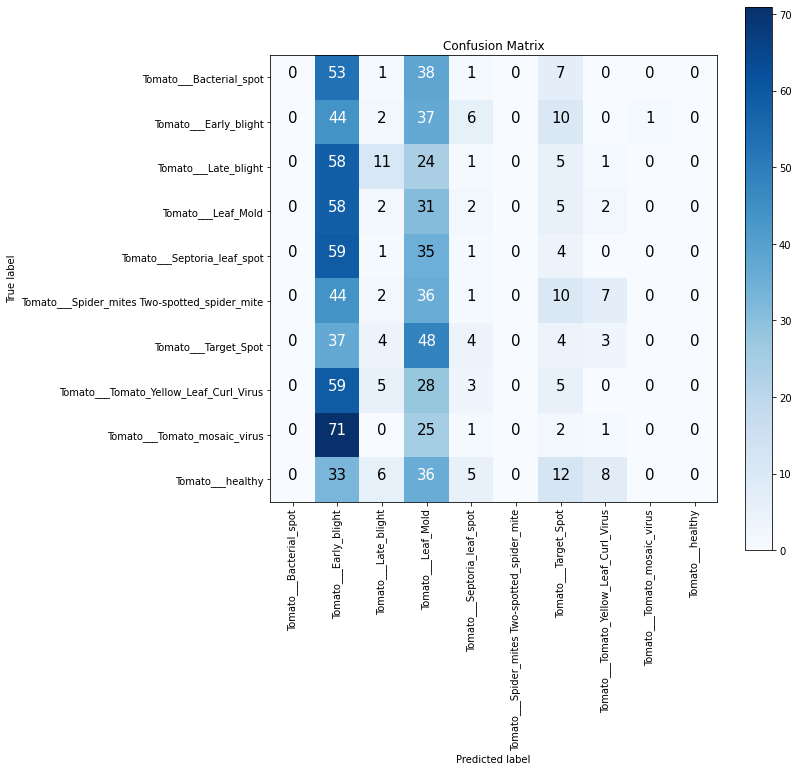

In [97]:
make_confusion_matrix(y_true, y_pred, class_names)

In [99]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the ground truth labels and predicted labels stored in numpy arrays
# y_true: numpy array of ground truth labels
# y_pred: numpy array of predicted labels

# Convert the predicted probabilities to predicted class labels
#y_pred_class = np.argmax(y_pred, axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.091
Precision: 0.06030167059255242
Recall: 0.091
F1 Score: 0.051336924655515793


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# #Done !

# #Implimentation of MobileNet Model!

In [110]:
import tensorflow as tf

# Load the pre-trained MobileNet model without the top classification layers
mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
mobilenet.trainable = False

# Create your own classification layers
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    mobilenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


In [111]:
model4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_7 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               12845312  
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
Total params: 16,076,746
Trainable params: 12,847,882
Non-trainable params: 3,228,864
_________________________________________________________________


In [112]:
# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [113]:
# Model fitting
history = model4.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)


Epoch 1/20
313/313 [==============================] - 12s 35ms/step - loss: 2.7892 - accuracy: 0.2654 - val_loss: 1.7932 - val_accuracy: 0.3870
Epoch 2/20
313/313 [==============================] - 10s 32ms/step - loss: 1.7972 - accuracy: 0.3416 - val_loss: 1.4119 - val_accuracy: 0.5410
Epoch 3/20
313/313 [==============================] - 10s 33ms/step - loss: 1.6130 - accuracy: 0.4037 - val_loss: 1.3575 - val_accuracy: 0.6150
Epoch 4/20
313/313 [==============================] - 10s 34ms/step - loss: 1.5568 - accuracy: 0.4065 - val_loss: 1.2413 - val_accuracy: 0.6230
Epoch 5/20
313/313 [==============================] - 10s 32ms/step - loss: 1.5307 - accuracy: 0.4109 - val_loss: 1.1584 - val_accuracy: 0.6860
Epoch 6/20
313/313 [==============================] - 11s 35ms/step - loss: 1.4079 - accuracy: 0.4432 - val_loss: 0.9479 - val_accuracy: 0.6970
Epoch 7/20
313/313 [==============================] - 10s 33ms/step - loss: 1.3835 - accuracy: 0.4466 - val_loss: 0.9804 - val_accuracy:

In [138]:
model4.evaluate(train_data)

313/313 [==============================] - 8s 27ms/step - loss: 0.2131 - accuracy: 0.9535


[0.2131248563528061, 0.953499972820282]

In [139]:
model4.evaluate(test_data)

32/32 [==============================] - 2s 44ms/step - loss: 0.6815 - accuracy: 0.7890


[0.6815202236175537, 0.7889999747276306]

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [151]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

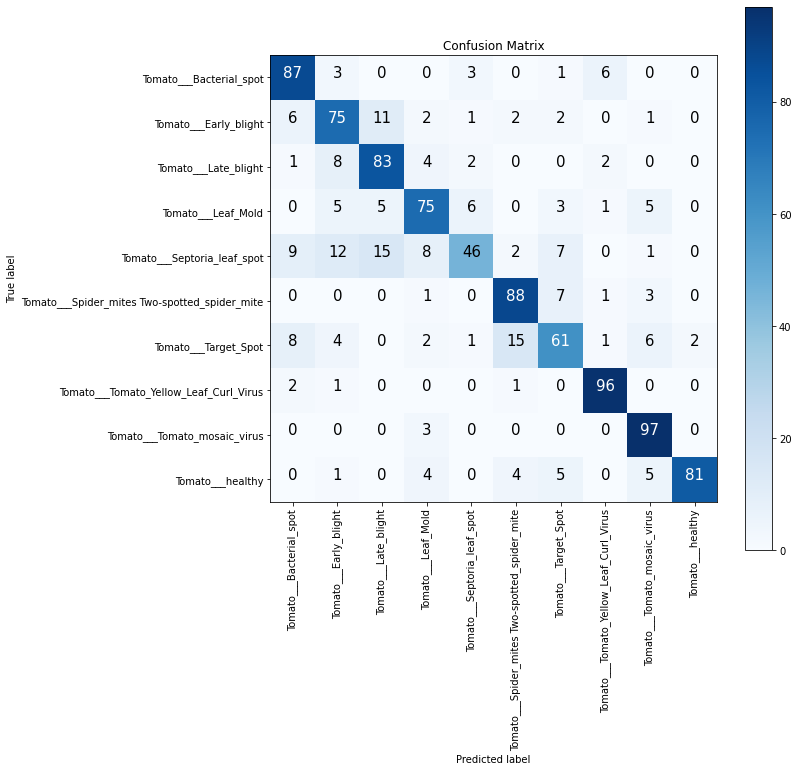

In [152]:
make_confusion_matrix(y_true, y_pred, class_names)

In [153]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the ground truth labels and predicted labels stored in numpy arrays
# y_true: numpy array of ground truth labels
# y_pred: numpy array of predicted labels

# Convert the predicted probabilities to predicted class labels
#y_pred_class = np.argmax(y_pred, axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.789
Precision: 0.791344223462454
Recall: 0.789
F1 Score: 0.7831483936878847


# #Done !

# #Implimentation of EfficientNetB0 Model!

In [156]:
import tensorflow as tf

# Load the pre-trained EfficientNetB0 model without the top classification layers
efficientnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
efficientnet.trainable = False

# Create your own classification layers
model5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    efficientnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


In [157]:
model5.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_10 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16056576  
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                2570      
Total params: 20,108,717
Trainable params: 16,059,146
Non-trainable params: 4,049,571
_________________________________________________________________


In [158]:

# Compile the model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [160]:
from tensorflow.keras.callbacks import EarlyStopping

In [161]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [163]:
# Model fitting
history = model5.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3454 - accuracy: 0.8752 - val_loss: 0.5372 - val_accuracy: 0.8870
Epoch 2/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3383 - accuracy: 0.8799 - val_loss: 0.4704 - val_accuracy: 0.9080
Epoch 3/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3300 - accuracy: 0.8807 - val_loss: 0.5296 - val_accuracy: 0.8970
Epoch 4/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3153 - accuracy: 0.8865 - val_loss: 0.6085 - val_accuracy: 0.8860
Epoch 5/20
313/313 [==============================] - 15s 48ms/step - loss: 0.3070 - accuracy: 0.8894 - val_loss: 0.4401 - val_accuracy: 0.8960
Epoch 6/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3049 - accuracy: 0.8922 - val_loss: 0.4630 - val_accuracy: 0.8940
Epoch 7/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3081 - accuracy: 0.8902 - val_loss: 0.6023 - val_accuracy:

In [165]:
model5.evaluate(train_data)

313/313 [==============================] - 13s 41ms/step - loss: 0.0099 - accuracy: 0.9968


[0.009887855499982834, 0.9968000054359436]

In [166]:
model5.evaluate(test_data)

32/32 [==============================] - 2s 52ms/step - loss: 0.7075 - accuracy: 0.8990


[0.7075234651565552, 0.8989999890327454]

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [180]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model5.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

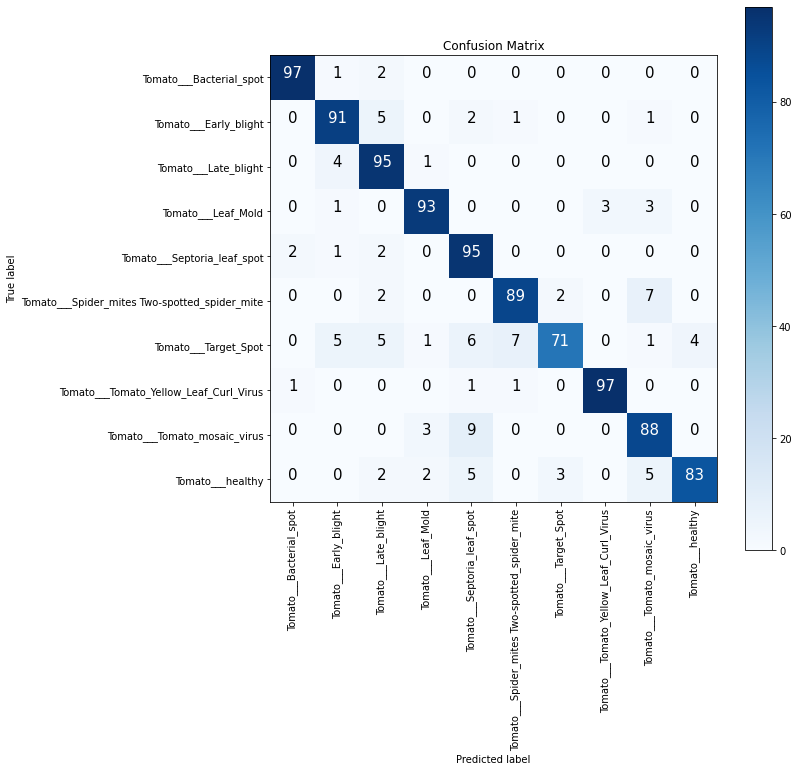

In [181]:
make_confusion_matrix(y_true, y_pred, class_names)

In [182]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the ground truth labels and predicted labels stored in numpy arrays
# y_true: numpy array of ground truth labels
# y_pred: numpy array of predicted labels

# Convert the predicted probabilities to predicted class labels
#y_pred_class = np.argmax(y_pred, axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.899
Precision: 0.9033779874218448
Recall: 0.899
F1 Score: 0.8982175337441469


In [184]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.97      0.97      0.97       100
                        Tomato___Early_blight       0.88      0.91      0.90       100
                         Tomato___Late_blight       0.84      0.95      0.89       100
                           Tomato___Leaf_Mold       0.93      0.93      0.93       100
                  Tomato___Septoria_leaf_spot       0.81      0.95      0.87       100
Tomato___Spider_mites Two-spotted_spider_mite       0.91      0.89      0.90       100
                         Tomato___Target_Spot       0.93      0.71      0.81       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.97      0.97       100
                 Tomato___Tomato_mosaic_virus       0.84      0.88      0.86       100
                             Tomato___healthy       0.95      0.83      0.89       100

                                     accu

# #Done!

# #Implimentation of Xception Model !

In [221]:
import tensorflow as tf

# Load the pre-trained Xception model without the top classification layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
xception.trainable = False

# Create your own classification layers
# Create your own classification layers
model6 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    xception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


In [222]:
model6.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)                2570      
Total params: 21,388,594
Trainable params: 527,114
Non-trainable params: 20,861,480
_________________________________________________________________


In [223]:
# Compile the model
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [224]:
from tensorflow.keras.callbacks import EarlyStopping

In [225]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [231]:
# Model fitting
history = model6.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/20
313/313 [==============================] - 28s 89ms/step - loss: 1.3591 - accuracy: 0.5096 - val_loss: 1.1583 - val_accuracy: 0.5940
Epoch 2/20
313/313 [==============================] - 28s 89ms/step - loss: 1.3317 - accuracy: 0.5149 - val_loss: 1.1317 - val_accuracy: 0.6220
Epoch 3/20
313/313 [==============================] - 28s 89ms/step - loss: 1.2654 - accuracy: 0.5415 - val_loss: 1.0973 - val_accuracy: 0.6300
Epoch 4/20
313/313 [==============================] - 28s 89ms/step - loss: 1.2427 - accuracy: 0.5549 - val_loss: 1.0596 - val_accuracy: 0.6460
Epoch 5/20
313/313 [==============================] - 28s 89ms/step - loss: 1.2459 - accuracy: 0.5512 - val_loss: 1.0505 - val_accuracy: 0.6500
Epoch 6/20
313/313 [==============================] - 28s 89ms/step - loss: 1.2469 - accuracy: 0.5498 - val_loss: 1.0584 - val_accuracy: 0.6480
Epoch 7/20
313/313 [==============================] - 28s 89ms/step - loss: 1.2173 - accuracy: 0.5605 - val_loss: 1.1015 - val_accuracy:

In [232]:
model6.evaluate(train_data)

313/313 [==============================] - 25s 79ms/step - loss: 0.7809 - accuracy: 0.7495


[0.7809433341026306, 0.7494999766349792]

In [233]:
model6.evaluate(test_data)

32/32 [==============================] - 3s 91ms/step - loss: 0.9571 - accuracy: 0.6830


[0.9571375846862793, 0.6830000281333923]

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [235]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model6.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

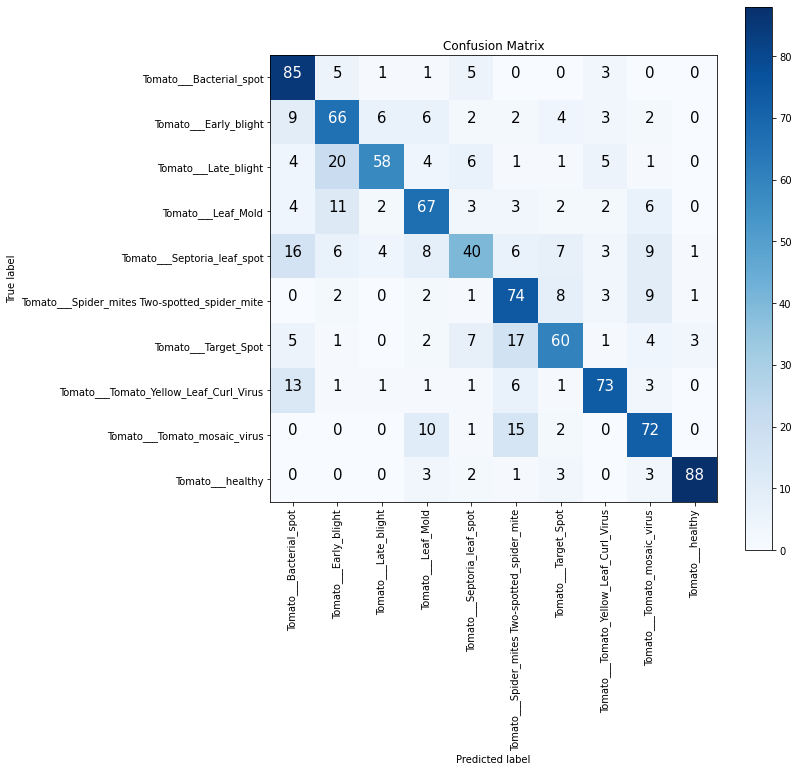

In [245]:
make_confusion_matrix(y_true, y_pred, class_names)

In [237]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the ground truth labels and predicted labels stored in numpy arrays
# y_true: numpy array of ground truth labels
# y_pred: numpy array of predicted labels

# Convert the predicted probabilities to predicted class labels
#y_pred_class = np.argmax(y_pred, axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.683
Precision: 0.6917858769422389
Recall: 0.683
F1 Score: 0.6803916966237116


In [238]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.62      0.85      0.72       100
                        Tomato___Early_blight       0.59      0.66      0.62       100
                         Tomato___Late_blight       0.81      0.58      0.67       100
                           Tomato___Leaf_Mold       0.64      0.67      0.66       100
                  Tomato___Septoria_leaf_spot       0.59      0.40      0.48       100
Tomato___Spider_mites Two-spotted_spider_mite       0.59      0.74      0.66       100
                         Tomato___Target_Spot       0.68      0.60      0.64       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.78      0.73      0.76       100
                 Tomato___Tomato_mosaic_virus       0.66      0.72      0.69       100
                             Tomato___healthy       0.95      0.88      0.91       100

                                     accu

# #Done!

# #Implimentation of InceptionResNetV2 Model !

In [211]:
import tensorflow as tf

# Load the pre-trained InceptionResNetV2 model without the top classification layers
inception_resnet = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
inception_resnet.trainable = False

# Create your own classification layers
model7 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    inception_resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


In [212]:
model7.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                2570      
Total params: 54,732,778
Trainable params: 396,042
Non-trainable params: 54,336,736
_________________________________________________________________


In [213]:
# Compile the model
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [214]:
from tensorflow.keras.callbacks import EarlyStopping

In [215]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [216]:
# Model fitting
history = model7.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/20
313/313 [==============================] - 55s 141ms/step - loss: 9.8654 - accuracy: 0.0972 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/20
313/313 [==============================] - 40s 127ms/step - loss: 2.3028 - accuracy: 0.0945 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/20
313/313 [==============================] - 40s 127ms/step - loss: 2.3028 - accuracy: 0.0953 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/20
313/313 [==============================] - 40s 127ms/step - loss: 2.3028 - accuracy: 0.0957 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/20
 76/313 [======>.......................] - ETA: 27s - loss: 2.3026 - accuracy: 0.0995

KeyboardInterrupt: 

In [ ]:
model7.evaluate(train_data)

In [ ]:
model7.evaluate(test_data)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [ ]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model7.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

In [ ]:
make_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the ground truth labels and predicted labels stored in numpy arrays
# y_true: numpy array of ground truth labels
# y_pred: numpy array of predicted labels

# Convert the predicted probabilities to predicted class labels
#y_pred_class = np.argmax(y_pred, axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))    